In [1]:
import match as m
import random
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("pdf")

match.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/pedro/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/lib/python2.7/dist-packages/tornado/ioloop.py", line 866, in start
    hand

In [2]:
random_seed = random.randint(1, 262571)
random.seed(a=random_seed)
np.random.seed(seed=random_seed)

In [3]:
transformation = m.generate_transformation()

theta: 347


In [4]:
print("Transformation matrix:")
print(transformation)


Transformation matrix:
[[  0.97437006   0.22495105 -49.        ]
 [ -0.22495105   0.97437006  40.        ]
 [  0.           0.           1.        ]]


In [5]:
dataset = m.generate_dataset(transformation)

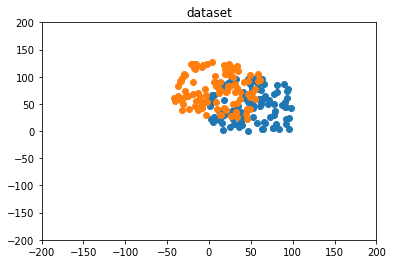

In [6]:
m.show_dataset(dataset)

In [7]:
opt_dataset = m.optimize(dataset)

  Iterations : 30
  Calculated : [7.00445826 2.22720263 0.0971233 ]


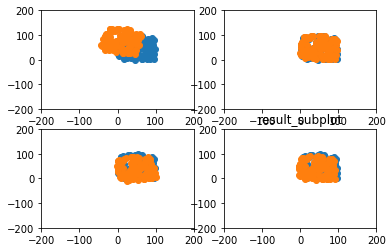

In [8]:
m.show_dataset(opt_dataset, name = "result_subplot", subplot = True)

In [9]:
a, b, r = opt_dataset
dataset = (a, b)

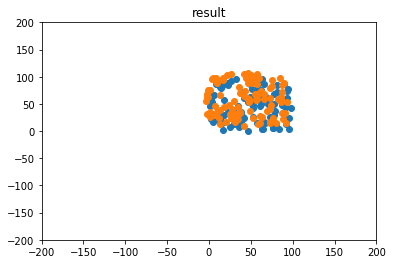

In [10]:
m.show_dataset(dataset, name = "result")